# VIX Premium
Ing-Haw, Cheng, (2018), The Vix Premium

The author defines the vix premium as "the expected dollar loss for a long VIX futures contract with 1$ notional value held through expiration".

$$VIXP_{t}^T = E_{t}^Q[VIX_{T}]-E_{t}^P[VIX_{T}]$$

The VIX is the risk neutral expectation of realized variance over the next 30 days extracted from option prices such that:

$$VIX_{t} = \sqrt{E_{t}^Q[RV_{t,t+30}] }$$

So a VIX future expiring at time T is the risk neutral expectation at time t for VIX. That is why VIX futures are derivatives on a derivative.
The VIXP scaled for one month is given by:

$$\frac{21}{T(t)-t}[E_{t}^Q[VIX_{T(t)}]-E_{t}^P[VIX_{T(t)}]$$

Assuming no arbitrage the risk neutral expectation for VIX is given by the current futures contract:
$$F_{t}^{T(t)}=E_{t}^Q[VIX_{T}] $$
The conditional expectation for VIX  is estimated according to a baseline ARMA(2,2) model such that the VIXP is:
$$\frac{21}{T(t)-t}[F_{t}^{T(t)}-\widehat{VIX_{T(t)}}]$$
The author claims that VIXP falls or stays flat when conditional measures of risk increase. He attributes this to reduced hedging demand in periods of high risk. Furthermore the VIXP is a good predictor of VIX returns and falling VIXP predicts subsequent increases in market risk. He claims that this behavior creates profitable trading opportunities.

Evernote:https://www.evernote.com/shard/s20/nl/2254793/28c806fb-4650-43c9-86fc-282994a59a87/

In [1]:
from pathlib import Path   
import pandas as pd
import numpy as np
import pyfolio as pf
import pandas_datareader as web
from statsmodels.tsa.arima_model import ARMA

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.transforms as bbox
from matplotlib import rcParams
import seaborn as sns

import quandl
import nest_asyncio

import sys
import socket
opt_path = '/Users/ebellord/PycharmProjects/opt_trade'
if  opt_path not in sys.path:
    sys.path.append(opt_path)

if socket.gethostname() == 'edmunds-mbp.lan':
    %config InlineBackend.figure_format = 'retina'

from option_utilities import perf_stats, chart_format, PlotConstants
from option_simulation import OptionSimulation, plot_performance_quad, OptionTrades
from spx_data_update import UpdateSP500Data, ImpliedVolatilityHistory, \
    VixTSM, SP500Index, CBOEIndex
from implied_to_realized import SPX5MinuteBars
# from overlay_presentation import get_fund_assets

def table1_stats(df, name, mult=1):
    out_series = df.describe().copy()
    out_series[1:] = out_series[1:] * mult
    out_series['First'], out_series['Last'] = [df.index[item].strftime('%b-%y') for item in [0, -1]]
    out_series = out_series.reindex(['count', 'First', 'Last', 'mean', 'std', 'min',
                                    'max', '50%'])
    return out_series.rename(name)

# Data

In [2]:
nest_asyncio.apply()
pc = PlotConstants()

iv_hist = ImpliedVolatilityHistory()
vix = iv_hist.implied_vol_index

vixp_d, vixp_m = [pd.read_excel(UpdateSP500Data.DATA_BASE_PATH / 'xl' / 'VIX_Premium.xlsx', 
                           sheet_name=sheet_name) for sheet_name in ['Daily', 'Monthly']]
vixp_d['dt'], vixp_m['dt'] = [df['dt'].apply(pd.to_datetime) for df in [vixp_d, vixp_m]]
vixp_d, vixp_m = [df.set_index('dt') for df in [vixp_d, vixp_m]]
vixp_d.index.name, vixp_m.index.name = [None for df in [vixp_d, vixp_m]] 

sp5 = SP500Index(update=False)
cboe = CBOEIndex()
bars = SPX5MinuteBars(update_bars=False)

# VIX - VIXP - VIXR Descriptive Statistics

/Users/ebellord/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


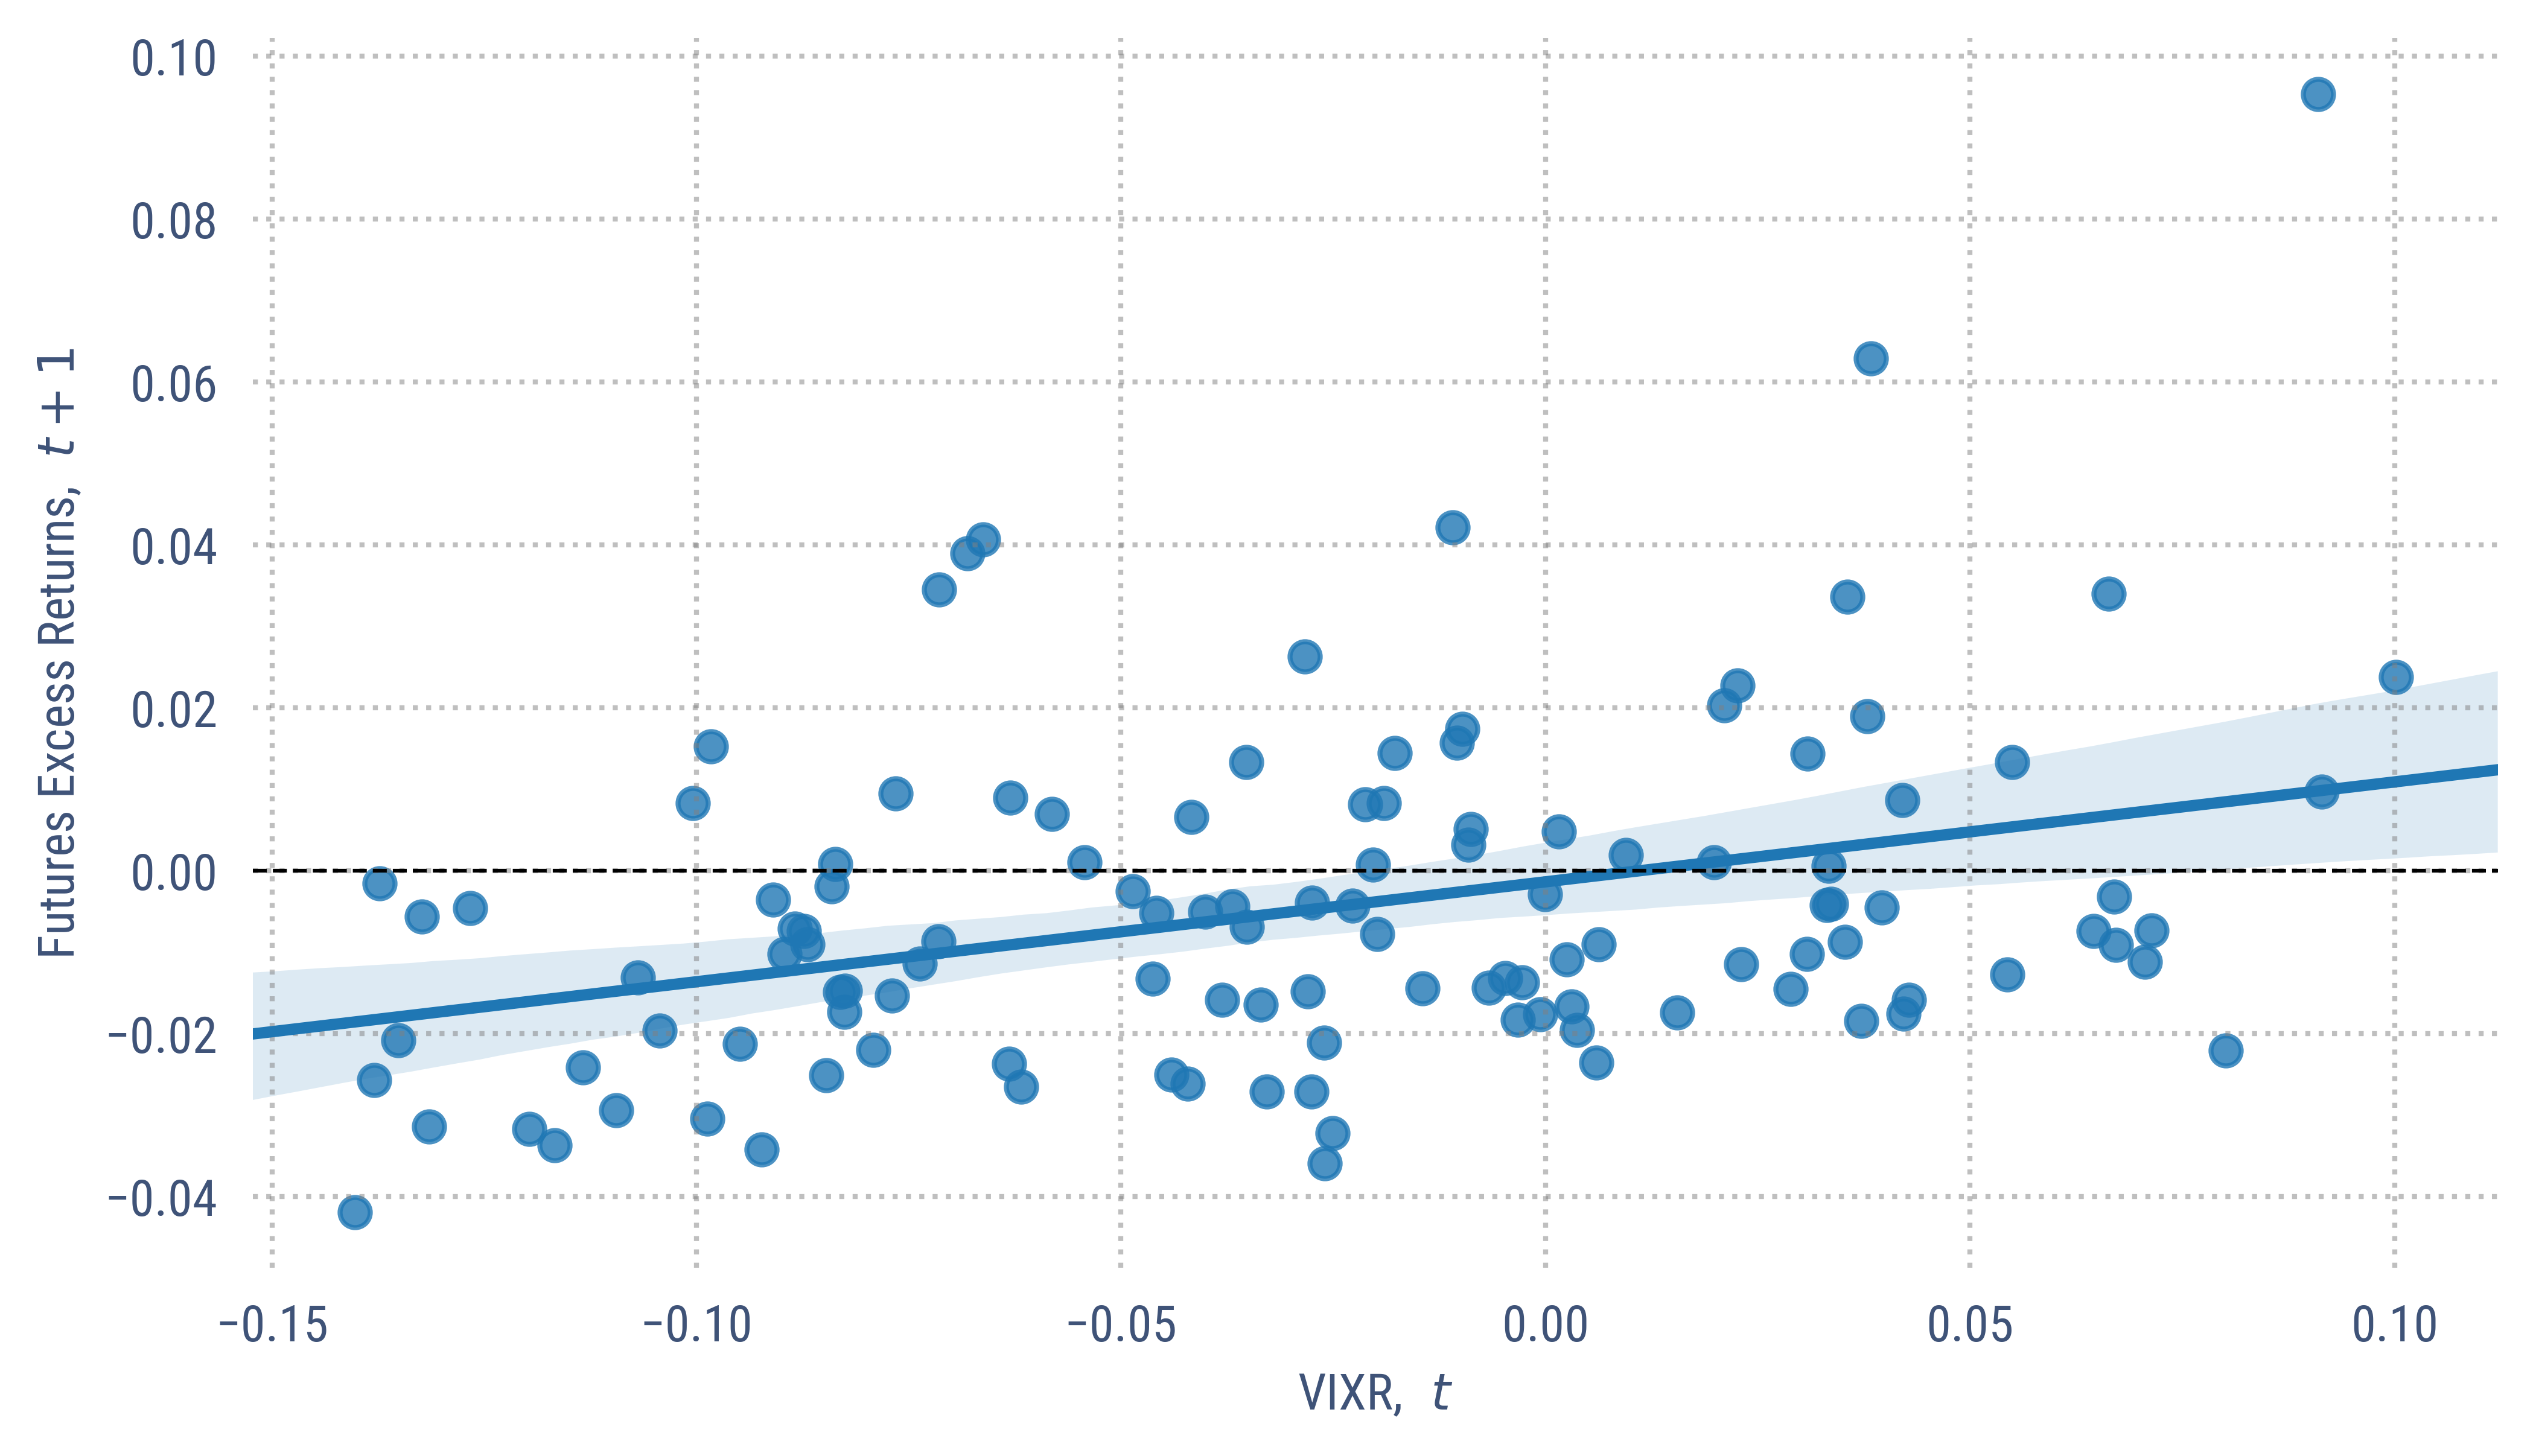

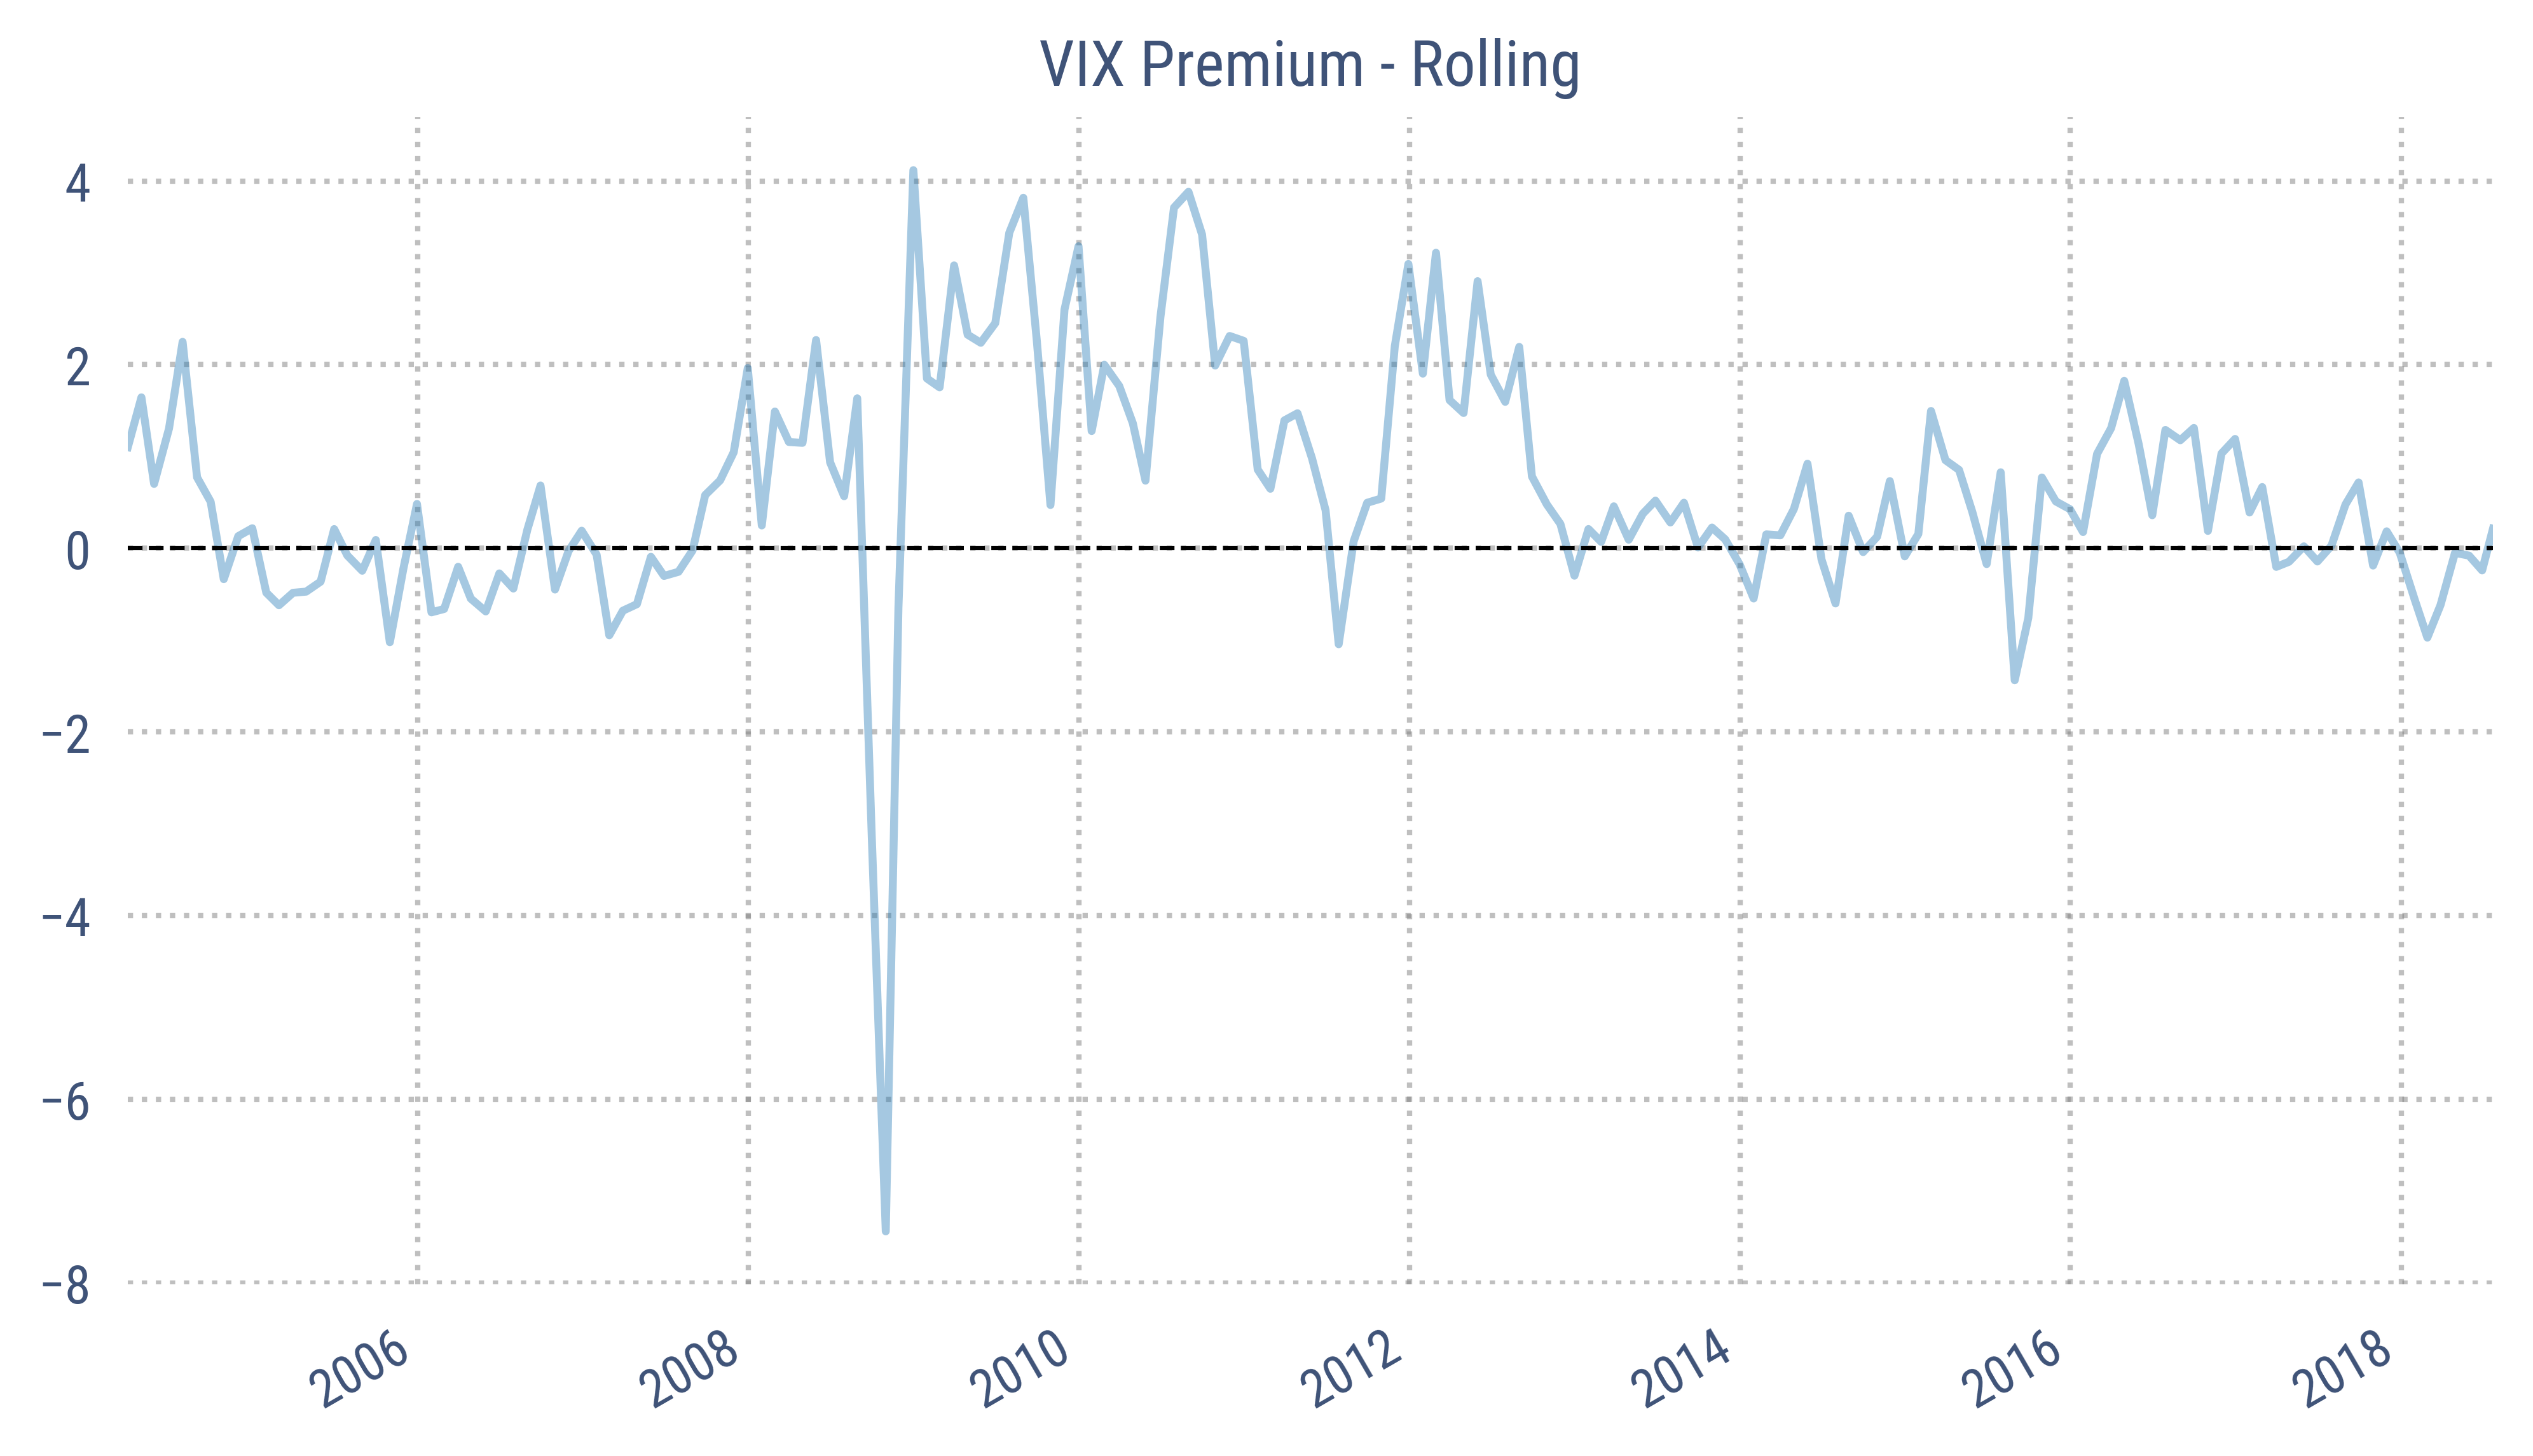

In [3]:
expiry_type = 'eom'
vx = VixTSM(expiry_type)
delever_constant = 8

vix_ret_monthly_col = vx.rolled_idx.resample('BM', closed='left').ffill().pct_change().dropna(how='any')
vix_fut_long_ret = vx.rolled_return.dropna(how='any') / delever_constant
vix_fut_short_ret = vx.rolled_return_short.dropna(how='any') / delever_constant

vixp_mm = vixp_m['vixr_2004'].resample('BM', closed='left').ffill()
vix_fut_long_idx = pf.timeseries.cum_returns(vix_fut_long_ret, 100)
vix_fut_long_idx_m = vix_fut_long_idx.resample('BM', closed='left').ffill()
vix_fut_long_ret_m = vix_fut_long_idx_m.pct_change().dropna(how='any')
vix_fut_long_ret_m = vix_fut_long_ret_m.rename('Long VIX futures')
vixp_mm_lag = vixp_mm.shift(1).dropna(how='any')

plot_data = pd.concat([vix_fut_long_ret_m, vixp_mm_lag], axis=1).dropna(how='any')
x = vixp_mm_lag.name
y = vix_fut_long_ret_m.name
fig = plt.figure(figsize=pc.fig_size,
                 dpi=600, 
                 facecolor='None', 
                 edgecolor='None')

gs = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.25)
ax_scat = plt.subplot(gs[:])
ax_plot = sns.regplot(x, y, data=plot_data)
ax_scat.axhline(0,
             color='k',
             ls='--',
             lw=0.75,
             alpha=1.0)
ax_scat.set_ylabel('Futures Excess Returns, $\ {t+1}$')
ax_scat.set_xlabel('VIXR, $\ t$')
chart_format([ax_scat],pc.color_light)

plt.autoscale(enable=True,
              axis='x',
              tight=True)

realized_vol = np.sqrt(bars.realized_variance * 12)
table1 = pd.concat([table1_stats(vix['03-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                                 'CBOE Volatility Index (VIX)'),
                    table1_stats(vx.rolled_future['02-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                                 'VIX Futures'),
                    table1_stats(vix_ret_monthly_col, 'VIX Futures return', 100),
                    table1_stats(vixp_m['vixp_2004'].dropna(how='any'), 'VIXP'),
                    table1_stats(vixp_m['vixr_2004'].dropna(how='any'), 'VIXR', 100),
                    table1_stats(realized_vol['02-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                                 'Realized Volatility', 100),
                    table1_stats(cboe.skew['03-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                               'CBOE SKEW Index'),
                    table1_stats(cboe.vvix['03-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                               'CBOE VVIX Index'),
                    table1_stats(sp5.return_index['03-2004':'11-2015'].resample('BM', closed='left').ffill().pct_change().dropna(how='any'),
                                'S&P 500 Excess', 100)], axis=1)

display(table1.transpose().style.set_caption('Table1. Monthly Summary Statistics').format({'mean': '{:,.3f}', 'std': '{:,.3f}', 'min': '{:,.2f}',
                                    'max': '{:,.3f}', '50%': '{:,.3f}'}))
fig = plt.figure(figsize=pc.fig_size,
                 dpi=600, 
                 facecolor='None', 
                 edgecolor='None')
gs = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.25)
ax_vixp = plt.subplot(gs[:])
ax_vixp = vixp_m['vixp_rolling'].plot(lw=1.5,
                                    ax=ax_vixp, 
                                    grid=True,
                                    alpha=0.4,
                                    title ='VIX Premium - Rolling')
ax_vixp.axhline(0,
             color='k',
             ls='--',
             lw=0.75,
             alpha=1.0)
chart_format([ax_vixp], pc.color_light)

plt.autoscale(enable=True,
              axis='x',
              tight=True)

# ARMA 2, 2 Model - Expanding/Rolling Window

/Users/ebellord/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: overflow encountered in square
  R_mat, T_mat)
/Users/ebellord/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: invalid value encountered in true_divide
  R_mat, T_mat)
/Users/ebellord/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


05-04-2004
06-04-2004
07-04-2004
08-04-2004
12-04-2004
13-04-2004
14-04-2004
15-04-2004
16-04-2004
19-04-2004
20-04-2004
21-04-2004
22-04-2004
23-04-2004
26-04-2004
27-04-2004
28-04-2004
29-04-2004
30-04-2004
03-05-2004
04-05-2004
05-05-2004
06-05-2004
07-05-2004
10-05-2004
11-05-2004
12-05-2004
13-05-2004
14-05-2004
17-05-2004
18-05-2004
19-05-2004
20-05-2004
21-05-2004
24-05-2004
25-05-2004
26-05-2004
27-05-2004
28-05-2004
01-06-2004
02-06-2004
03-06-2004
04-06-2004
07-06-2004
08-06-2004
09-06-2004
10-06-2004
14-06-2004
15-06-2004
16-06-2004
17-06-2004
18-06-2004
21-06-2004
22-06-2004
23-06-2004
24-06-2004
25-06-2004
28-06-2004
29-06-2004
30-06-2004
01-07-2004
02-07-2004
06-07-2004
07-07-2004
08-07-2004
09-07-2004
12-07-2004
13-07-2004
14-07-2004
15-07-2004
16-07-2004
19-07-2004
20-07-2004
21-07-2004
22-07-2004
23-07-2004
26-07-2004
27-07-2004
28-07-2004
29-07-2004
30-07-2004
02-08-2004
03-08-2004
04-08-2004
05-08-2004
06-08-2004
09-08-2004
10-08-2004
11-08-2004
12-08-2004
13-08-2004

22-03-2007
23-03-2007
26-03-2007
27-03-2007
28-03-2007
29-03-2007
30-03-2007
02-04-2007
03-04-2007
04-04-2007
05-04-2007
09-04-2007
10-04-2007
11-04-2007
12-04-2007
13-04-2007
16-04-2007
17-04-2007
18-04-2007
19-04-2007
20-04-2007
23-04-2007
24-04-2007
25-04-2007
26-04-2007
27-04-2007
30-04-2007
01-05-2007
02-05-2007
03-05-2007
04-05-2007
07-05-2007
08-05-2007
09-05-2007
10-05-2007
11-05-2007
14-05-2007
15-05-2007
16-05-2007
17-05-2007
18-05-2007
21-05-2007
22-05-2007
23-05-2007
24-05-2007
25-05-2007
29-05-2007
30-05-2007
31-05-2007
01-06-2007
04-06-2007
05-06-2007
06-06-2007
07-06-2007
08-06-2007
11-06-2007
12-06-2007
13-06-2007
14-06-2007
15-06-2007
18-06-2007
19-06-2007
20-06-2007
21-06-2007
22-06-2007
25-06-2007
26-06-2007
27-06-2007
28-06-2007
29-06-2007
02-07-2007
03-07-2007
05-07-2007
06-07-2007
09-07-2007
10-07-2007
11-07-2007
12-07-2007
13-07-2007
16-07-2007
17-07-2007
18-07-2007
19-07-2007
20-07-2007
23-07-2007
24-07-2007
25-07-2007
26-07-2007
27-07-2007
30-07-2007
31-07-2007

/Users/ebellord/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


21-11-2008
24-11-2008
25-11-2008
26-11-2008
28-11-2008
01-12-2008
02-12-2008
03-12-2008
04-12-2008
05-12-2008
08-12-2008
09-12-2008
10-12-2008
11-12-2008
12-12-2008
15-12-2008
16-12-2008
17-12-2008
18-12-2008
19-12-2008
22-12-2008
23-12-2008
24-12-2008
26-12-2008
29-12-2008
30-12-2008
31-12-2008
02-01-2009
05-01-2009
06-01-2009
07-01-2009
08-01-2009
09-01-2009
12-01-2009
13-01-2009
14-01-2009
15-01-2009
16-01-2009
20-01-2009
21-01-2009
22-01-2009
23-01-2009
26-01-2009
27-01-2009
28-01-2009
29-01-2009
30-01-2009
02-02-2009
03-02-2009
04-02-2009
05-02-2009
06-02-2009
09-02-2009
10-02-2009
11-02-2009
12-02-2009
13-02-2009
17-02-2009
18-02-2009
19-02-2009
20-02-2009
23-02-2009
24-02-2009
25-02-2009
26-02-2009
27-02-2009
02-03-2009
03-03-2009
04-03-2009
05-03-2009
06-03-2009
09-03-2009
10-03-2009
11-03-2009
12-03-2009
13-03-2009
16-03-2009
17-03-2009
18-03-2009
19-03-2009
20-03-2009
23-03-2009
24-03-2009
25-03-2009
26-03-2009
27-03-2009
30-03-2009
31-03-2009
01-04-2009
02-04-2009
03-04-2009

07-11-2011
08-11-2011
09-11-2011
10-11-2011
11-11-2011
14-11-2011
15-11-2011
16-11-2011
17-11-2011
18-11-2011
21-11-2011
22-11-2011
23-11-2011
25-11-2011
28-11-2011
29-11-2011
30-11-2011
01-12-2011
02-12-2011
05-12-2011
06-12-2011
07-12-2011
08-12-2011
09-12-2011
12-12-2011
13-12-2011
14-12-2011
15-12-2011
16-12-2011
19-12-2011
20-12-2011
21-12-2011
22-12-2011
23-12-2011
27-12-2011
28-12-2011
29-12-2011
30-12-2011
03-01-2012
04-01-2012
05-01-2012
06-01-2012
09-01-2012
10-01-2012
11-01-2012
12-01-2012
17-01-2012
18-01-2012
19-01-2012
20-01-2012
23-01-2012
24-01-2012
25-01-2012
26-01-2012
27-01-2012
30-01-2012
31-01-2012
01-02-2012
02-02-2012
03-02-2012
06-02-2012
07-02-2012
08-02-2012
09-02-2012
10-02-2012
13-02-2012
14-02-2012
15-02-2012
16-02-2012
17-02-2012
21-02-2012
22-02-2012
23-02-2012
24-02-2012
27-02-2012
28-02-2012
29-02-2012
01-03-2012
02-03-2012
05-03-2012
06-03-2012
07-03-2012
08-03-2012
09-03-2012
12-03-2012
13-03-2012
14-03-2012
15-03-2012
16-03-2012
19-03-2012
20-03-2012

vixp_rolling  vixp_calc_rolling
vixp_rolling           1.000000           0.832384
vixp_calc_rolling      0.832384           1.000000

vixr_rolling  vixp_calc_rolling
vixr_rolling           1.000000           0.862819
vixp_calc_rolling      0.862819           1.000000

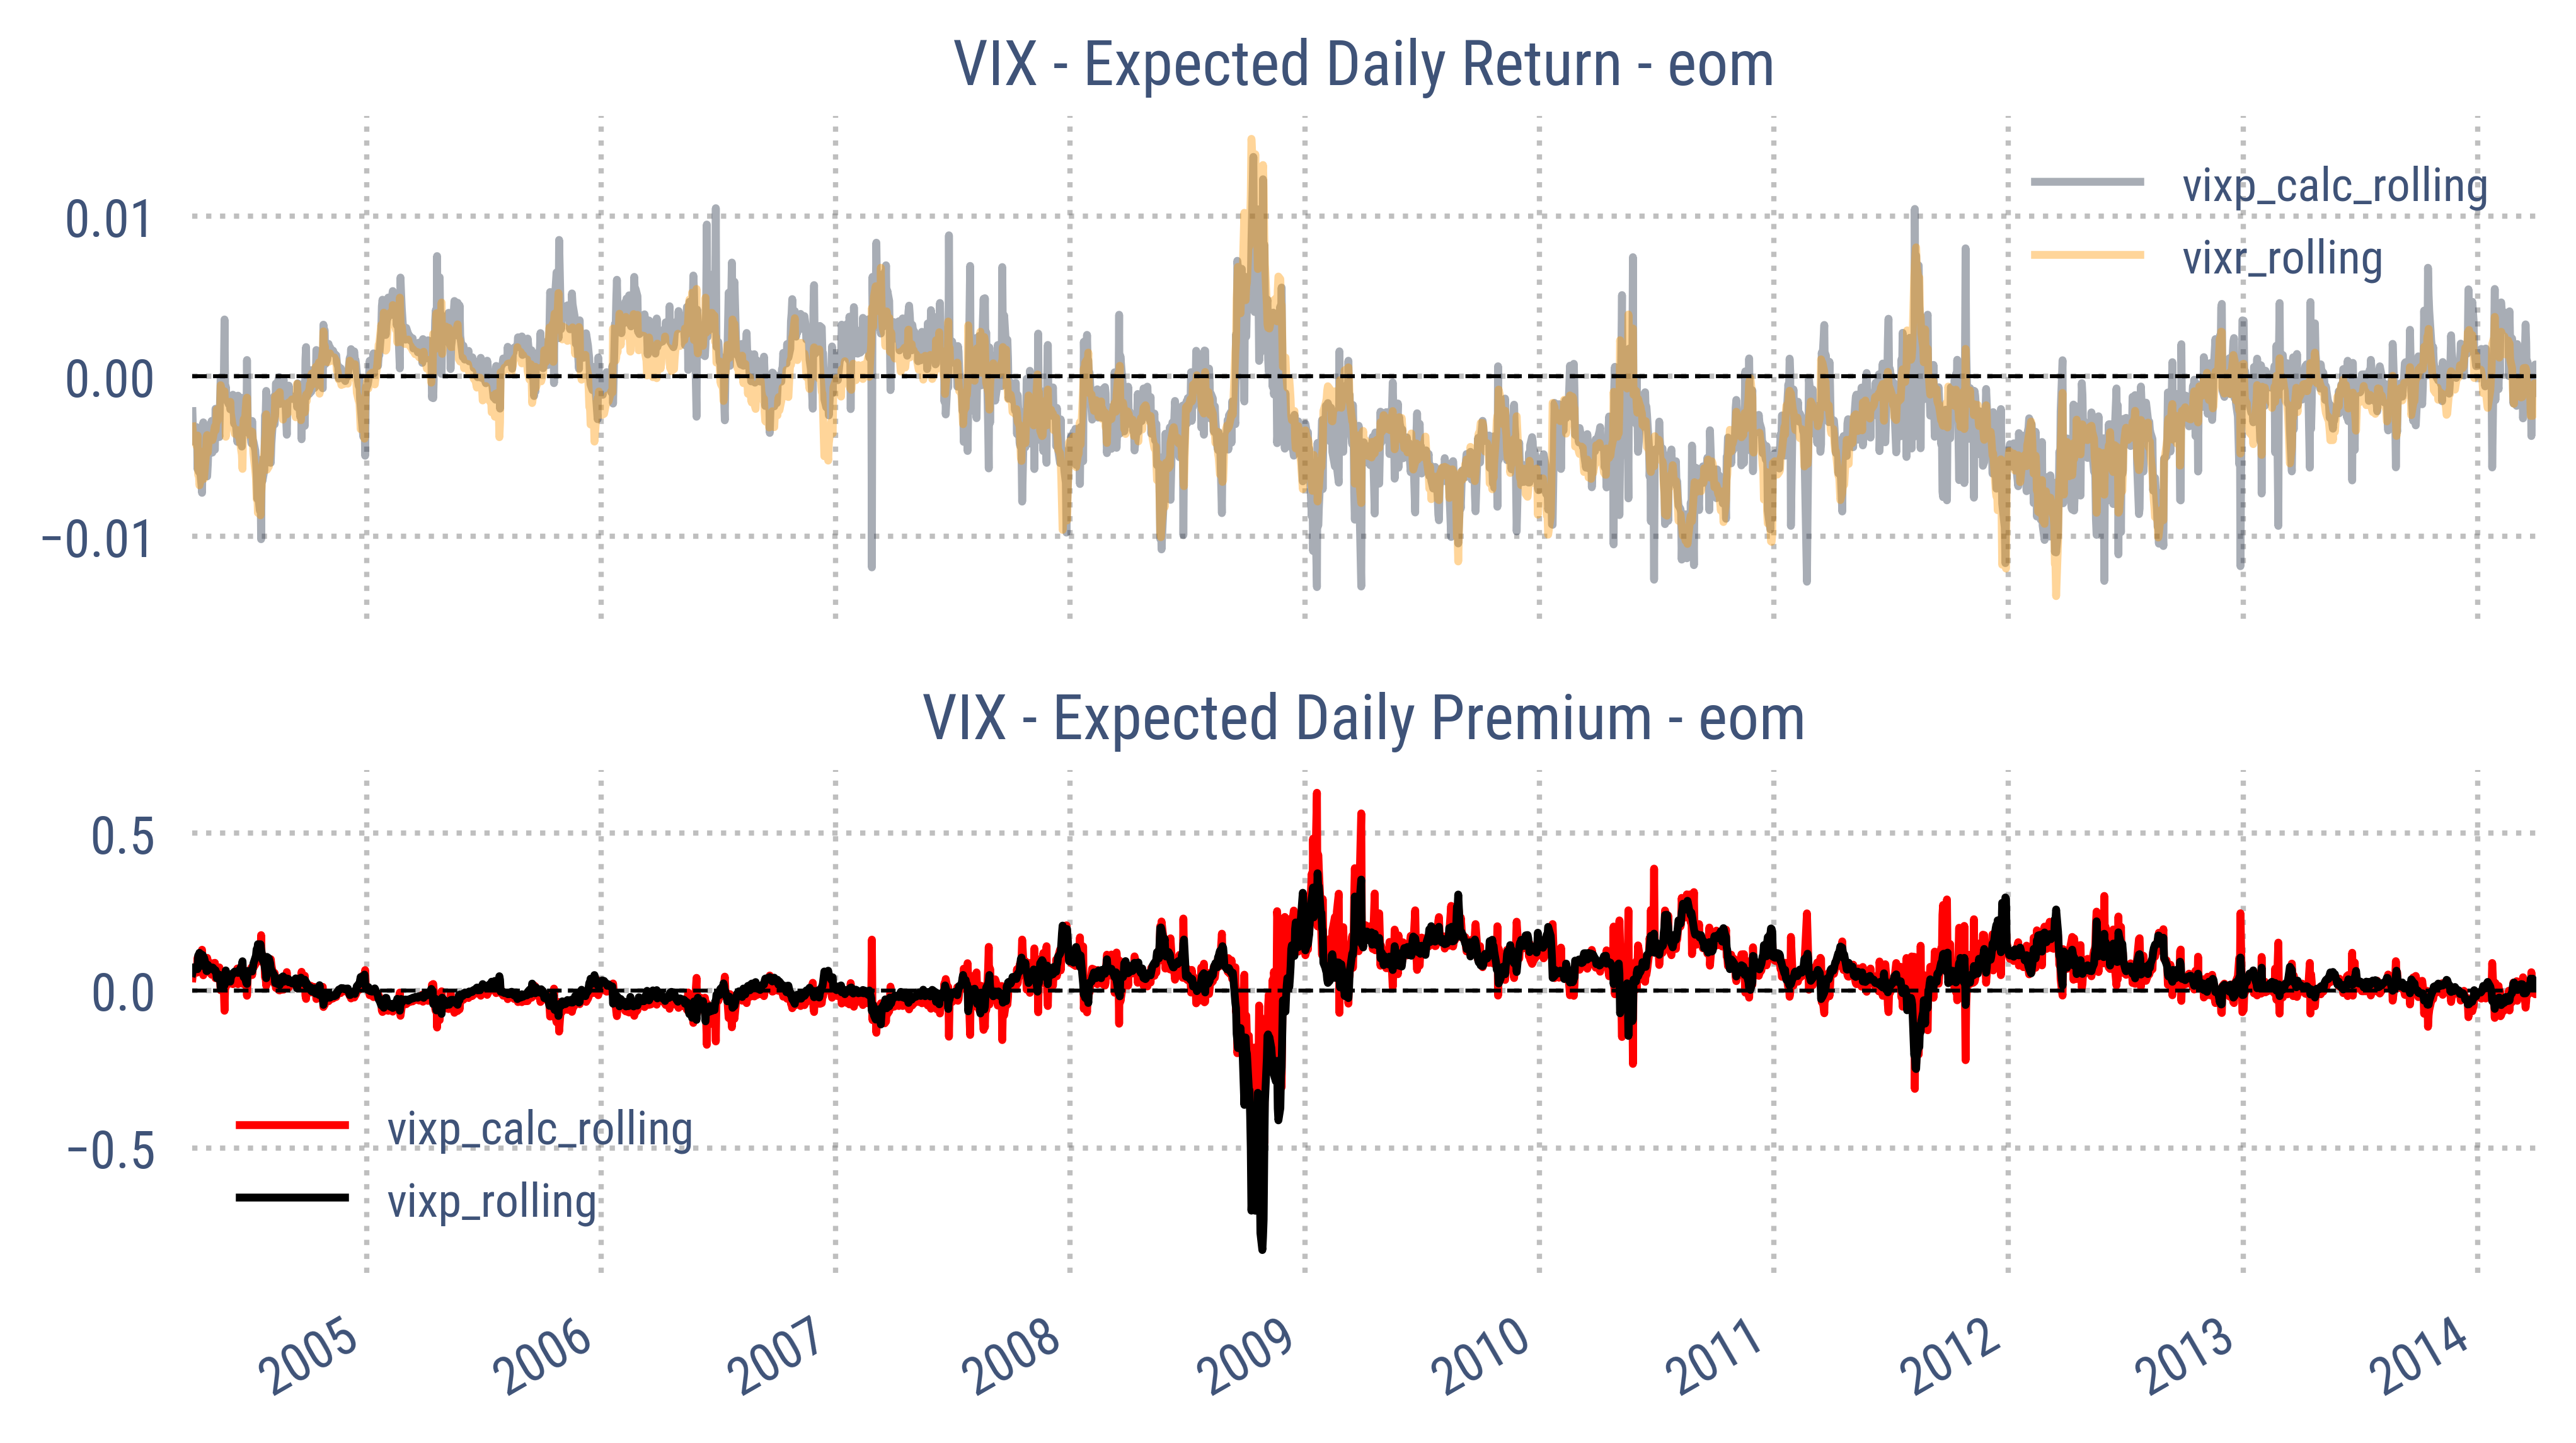

In [36]:
do_ARMA = True
rolling_window = True
log_vix = False
short_10y_window = True
if do_ARMA:
    train, test = vix[:vx.rolled_idx.index[0]][:-1], vix[vx.rolled_idx.index[:]]
    if short_10y_window:
        train = train.last('10Y')
    if log_vix:
        train, test = [np.log(item) for item in [train, test]]
    
    steps_days = vx.days_2_exp
    futures = vx.rolled_future

    history = [x for x in train]
    predictions = list()
    yhat_ts = []
    vixp_ts = []
    vixer_ts = []
    for t in range(len(test)):
        model = ARMA(history, order=(2, 2))
        model_fit = model.fit(disp=0,
                              start_params=[20.083, 1.651, -0.654, -0.714, -0.064],
                              transparams= False)
        output = model_fit.forecast(steps=steps_days[t])
        yhat = output[0]
        if log_vix:
            yhat = np.exp(yhat)
        obs = test[t]
        history.append(obs)
        if rolling_window:
            history = history[1:] # remove first observation
        yhat_ts.append(yhat[-1])
        vixp = (futures[t] - yhat[-1]) * (1 / steps_days[t])
        vixer = (yhat[-1]/futures[t]) ** (1 / steps_days[t]) - 1
        vixp_ts.append(vixp)
        vixer_ts.append(vixer)
        print(steps_days.index[t].strftime('%d-%m-%Y'))

        
    vixr_calc, vixp_calc = [pd.Series(index=test.index, data=item, name='vixp_calc_rolling') for item, name in 
                           zip([vixer_ts, vixp_ts], ['vixr_calc_rolling', 'vixp_calc_rolling'])]

    fig = plt.figure(figsize=pc.fig_size,
                     dpi=600, 
                     facecolor='None', 
                     edgecolor='None')
    gs = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.3)

    ax_vixr = plt.subplot(gs[0, :])
    ax_vixp_test = plt.subplot(gs[1, :], sharex=ax_vixr)

    _ = vixr_calc.plot(color=pc.color_dark,
                                  lw=1.5,
                                  ax=ax_vixr, 
                                  grid=True,
                                  alpha=0.4,
                                  title ='VIX - Expected Daily Return - {}'.format(expiry_type))
    chart_format([ax_vixr], pc.color_light)
    ax2 = vixp_d['vixr_rolling'][test.index].plot(secondary_y=False,
                                            ax=ax_vixr,
                                            color=pc.color_yellow,
                                            lw=1.5,
                                            alpha=0.4)
    ax_vixr.axhline(0,
                 color='k',
                 ls='--',
                 lw=0.75,
                 alpha=1.0)
    legend_1 = ax_vixr.legend(framealpha=0.0)

    vixp_calc.plot(color='r', ax=ax_vixp_test, title ='VIX - Expected Daily Premium - {}'.format(expiry_type))
    vixp_d['vixp_rolling'][test.index].plot(secondary_y=False, ax=plt.gca(), color='k')
    chart_format([plt.gca()], pc.color_light)
    legend_2 = ax_vixp_test.legend(framealpha=0.0)

    [(text.set_size(pc.font_size), text.set_color(pc.color_light)) for text in legend_1.get_texts() + 
                                                                                legend_2.get_texts()]
    chart_format([ax2, ax_vixp_test], pc.color_light)
    ax_vixp_test.axhline(0,
                 color='k',
                 ls='--',
                 lw=0.75,
                 alpha=1.0)
    plt.autoscale(enable=True,
                  axis='x',
                  tight=True)

    # Tables and Correlations
    table3 = pd.concat([table1_stats(vixp_d['vixp_rolling'][vixp_calc.index[0]:vixp_calc.index[-1]].dropna(how='any'), 'VIXP', 100),
                        table1_stats(vixp_calc.dropna(how='any'), 'VIXP_calc', 100),
                        table1_stats(vixp_d['vixr_rolling'][vixp_calc.index[0]:vixp_calc.index[-1]].dropna(how='any'), 'VIXR', 100),
                        table1_stats(vixr_calc.dropna(how='any'), 'VIXR_calc', 100)], axis=1)

    display(table3.transpose().style.set_caption('Table2. Daily Summary Statistics').format({'mean': '{:,.3f}', 'std': '{:,.3f}', 'min': '{:,.2f}',
                                        'max': '{:,.3f}', '50%': '{:,.3f}'}))
    display(pd.concat([vixp_d['vixp_rolling'][vixp_calc.index[0]:vixp_calc.index[-1]], vixp_calc], axis=1).corr())
    display(pd.concat([vixp_d['vixr_rolling'], vixr_calc], axis=1).corr())

# Daily VIX Premium strategy
Simple trading strategy that goes short rolling VIX futures when VIXP is positive and goes long same when VIXP is negative

L/S           S/-           L/-  \
StartDate                Apr 05, 2004  Apr 05, 2004  Apr 05, 2004   
EndDate                  Apr 03, 2014  Apr 03, 2014  Apr 03, 2014   
annual_return                 0.12472      0.106044     0.0168857   
annual_volatility           0.0700886      0.058267      0.039136   
sharpe_ratio                  1.71264       1.75959      0.447422   
calmar_ratio                 0.865612       1.67144     0.0946581   
stability_of_timeseries      0.940464      0.946325      0.817791   
max_drawdown                -0.144083    -0.0634444     -0.178386   
omega_ratio                   1.35903       1.45123       1.16346   
sortino_ratio                 2.69657       2.66124      0.785193   
skew                         0.411992    -0.0466219       3.20015   
kurtosis                      4.86861       5.19073        39.621   
tail_ratio                     1.1992       1.10078       1.12418   

                            short_vix             0     S&P 500TR  
StartDate                Apr 06, 2004  Apr 05, 2004  Apr 06, 2004  
EndDate                  Apr 03, 2014  Apr 03, 2014  Apr 04, 2014  
annual_return               0.0988436    -0.0582726      0.071573  
annual_volatility           0.0692688     0.0705041      0.204133  
sharpe_ratio                  1.39594     -0.816486      0.440943  
calmar_ratio                 0.597281     -0.126896      0.129543  
stability_of_timeseries      0.940435     -0.855994      0.618424  
max_drawdown                -0.165489     -0.459215     -0.552502  
omega_ratio                   1.28061      0.863674       1.09108  
sortino_ratio                 2.00884      -1.22532      0.619094  
skew                        -0.346794      0.963016     -0.072346  
kurtosis                      3.69876       5.28875       11.2887  
tail_ratio                    1.01389       1.10417      0.914602

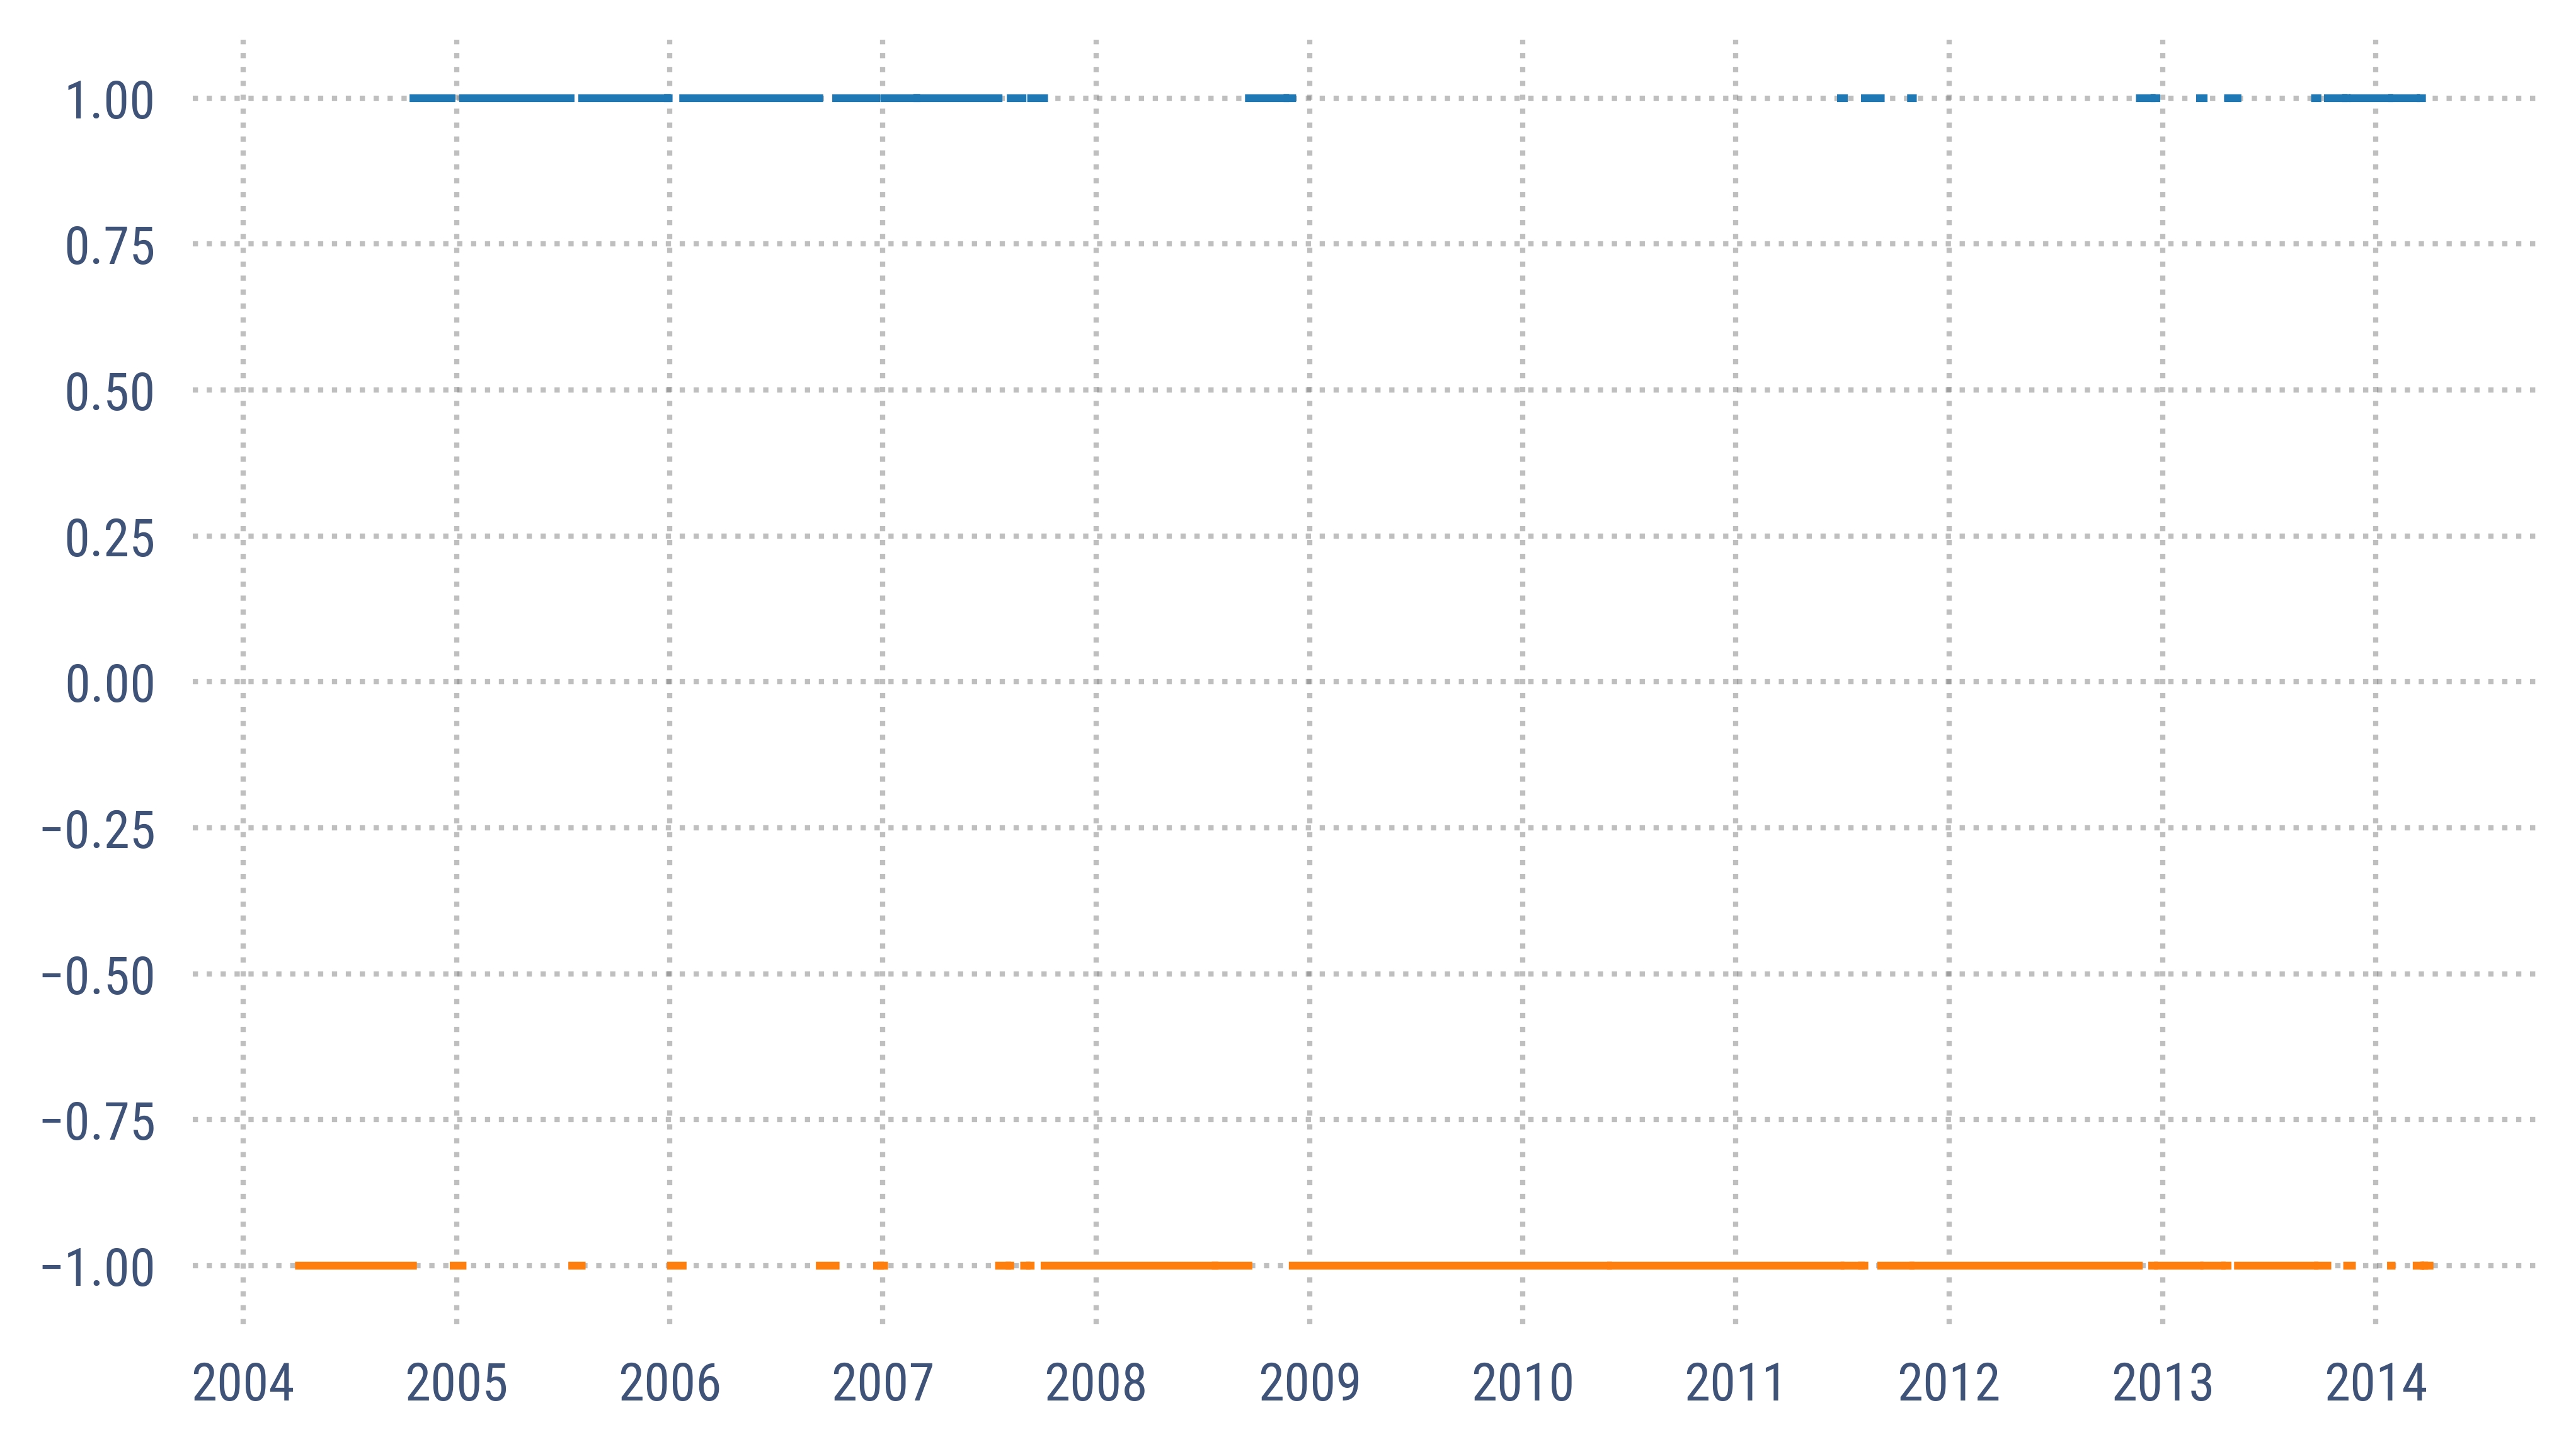

In [77]:
use_ARMA = True
if use_ARMA:
    vixp_signal = vixr_calc.shift(1).dropna(how='any')
else:
    vixp_signal = vixp_d['vixr_2004'].shift(1).dropna(how='any')

ewma = True
if ewma:
    vixp_signal = vixp_signal.ewm(alpha=0.2).mean()

vixp_signal = vixp_signal.reindex(vix_fut_short_ret.index)
short_signal = vixp_signal < 0
long_signal = ~short_signal
signal_ret = pd.concat([short_signal.astype(int) * vix_fut_short_ret, 
                   long_signal.astype(int) * vix_fut_long_ret], axis=1)
signal_ret['L/S'] = signal_ret.sum(axis=1)
signal_ret = signal_ret.rename(columns={0:'S/-', 1:'L/-'})

display(pd.concat([perf_stats(signal_ret['L/S']),
           perf_stats(signal_ret['S/-']),
           perf_stats(signal_ret['L/-']),
           perf_stats(vix_fut_short_ret),
           perf_stats(vix_fut_long_ret),
           perf_stats(sp5.return_index['04-05-2004':'04-04-2014'].pct_change().dropna(how='any'))], axis=1))
fig = plt.figure(figsize=pc.fig_size,
                 dpi=600, 
                 facecolor='None', 
                 edgecolor='None')
gs = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.25)
ax_pos = plt.subplot(gs[:])
short_weight = - short_signal.astype(int)
short_weight = short_weight.replace(0, np.nan)
long_weight = long_signal.astype(int)
long_weight = long_weight.replace(0, np.nan)
_ = plt.plot(long_weight)
_ = plt.plot(short_weight)
chart_format([ax_pos], pc.color_light)


# S&P 500 Beta Hedge

L/S_hedge           L/S    Beta_hedge
StartDate                Apr 05, 2004  Apr 05, 2004  Apr 06, 2004
EndDate                  Apr 03, 2014  Apr 03, 2014  Apr 03, 2014
annual_return                0.105514       0.12472    -0.0197073
annual_volatility           0.0467124     0.0700886     0.0510353
sharpe_ratio                  2.17156       1.71264     -0.364553
calmar_ratio                 0.987436      0.865612    -0.0708212
stability_of_timeseries      0.950388      0.940464     -0.881564
max_drawdown                -0.106856     -0.144083     -0.278268
omega_ratio                   1.50045       1.35903      0.930408
sortino_ratio                 3.59335       2.69657     -0.507343
skew                         0.730933      0.411992     0.0404946
kurtosis                      8.01769       4.86861       11.2443
tail_ratio                    1.30717        1.1992       1.04763

/Users/ebellord/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


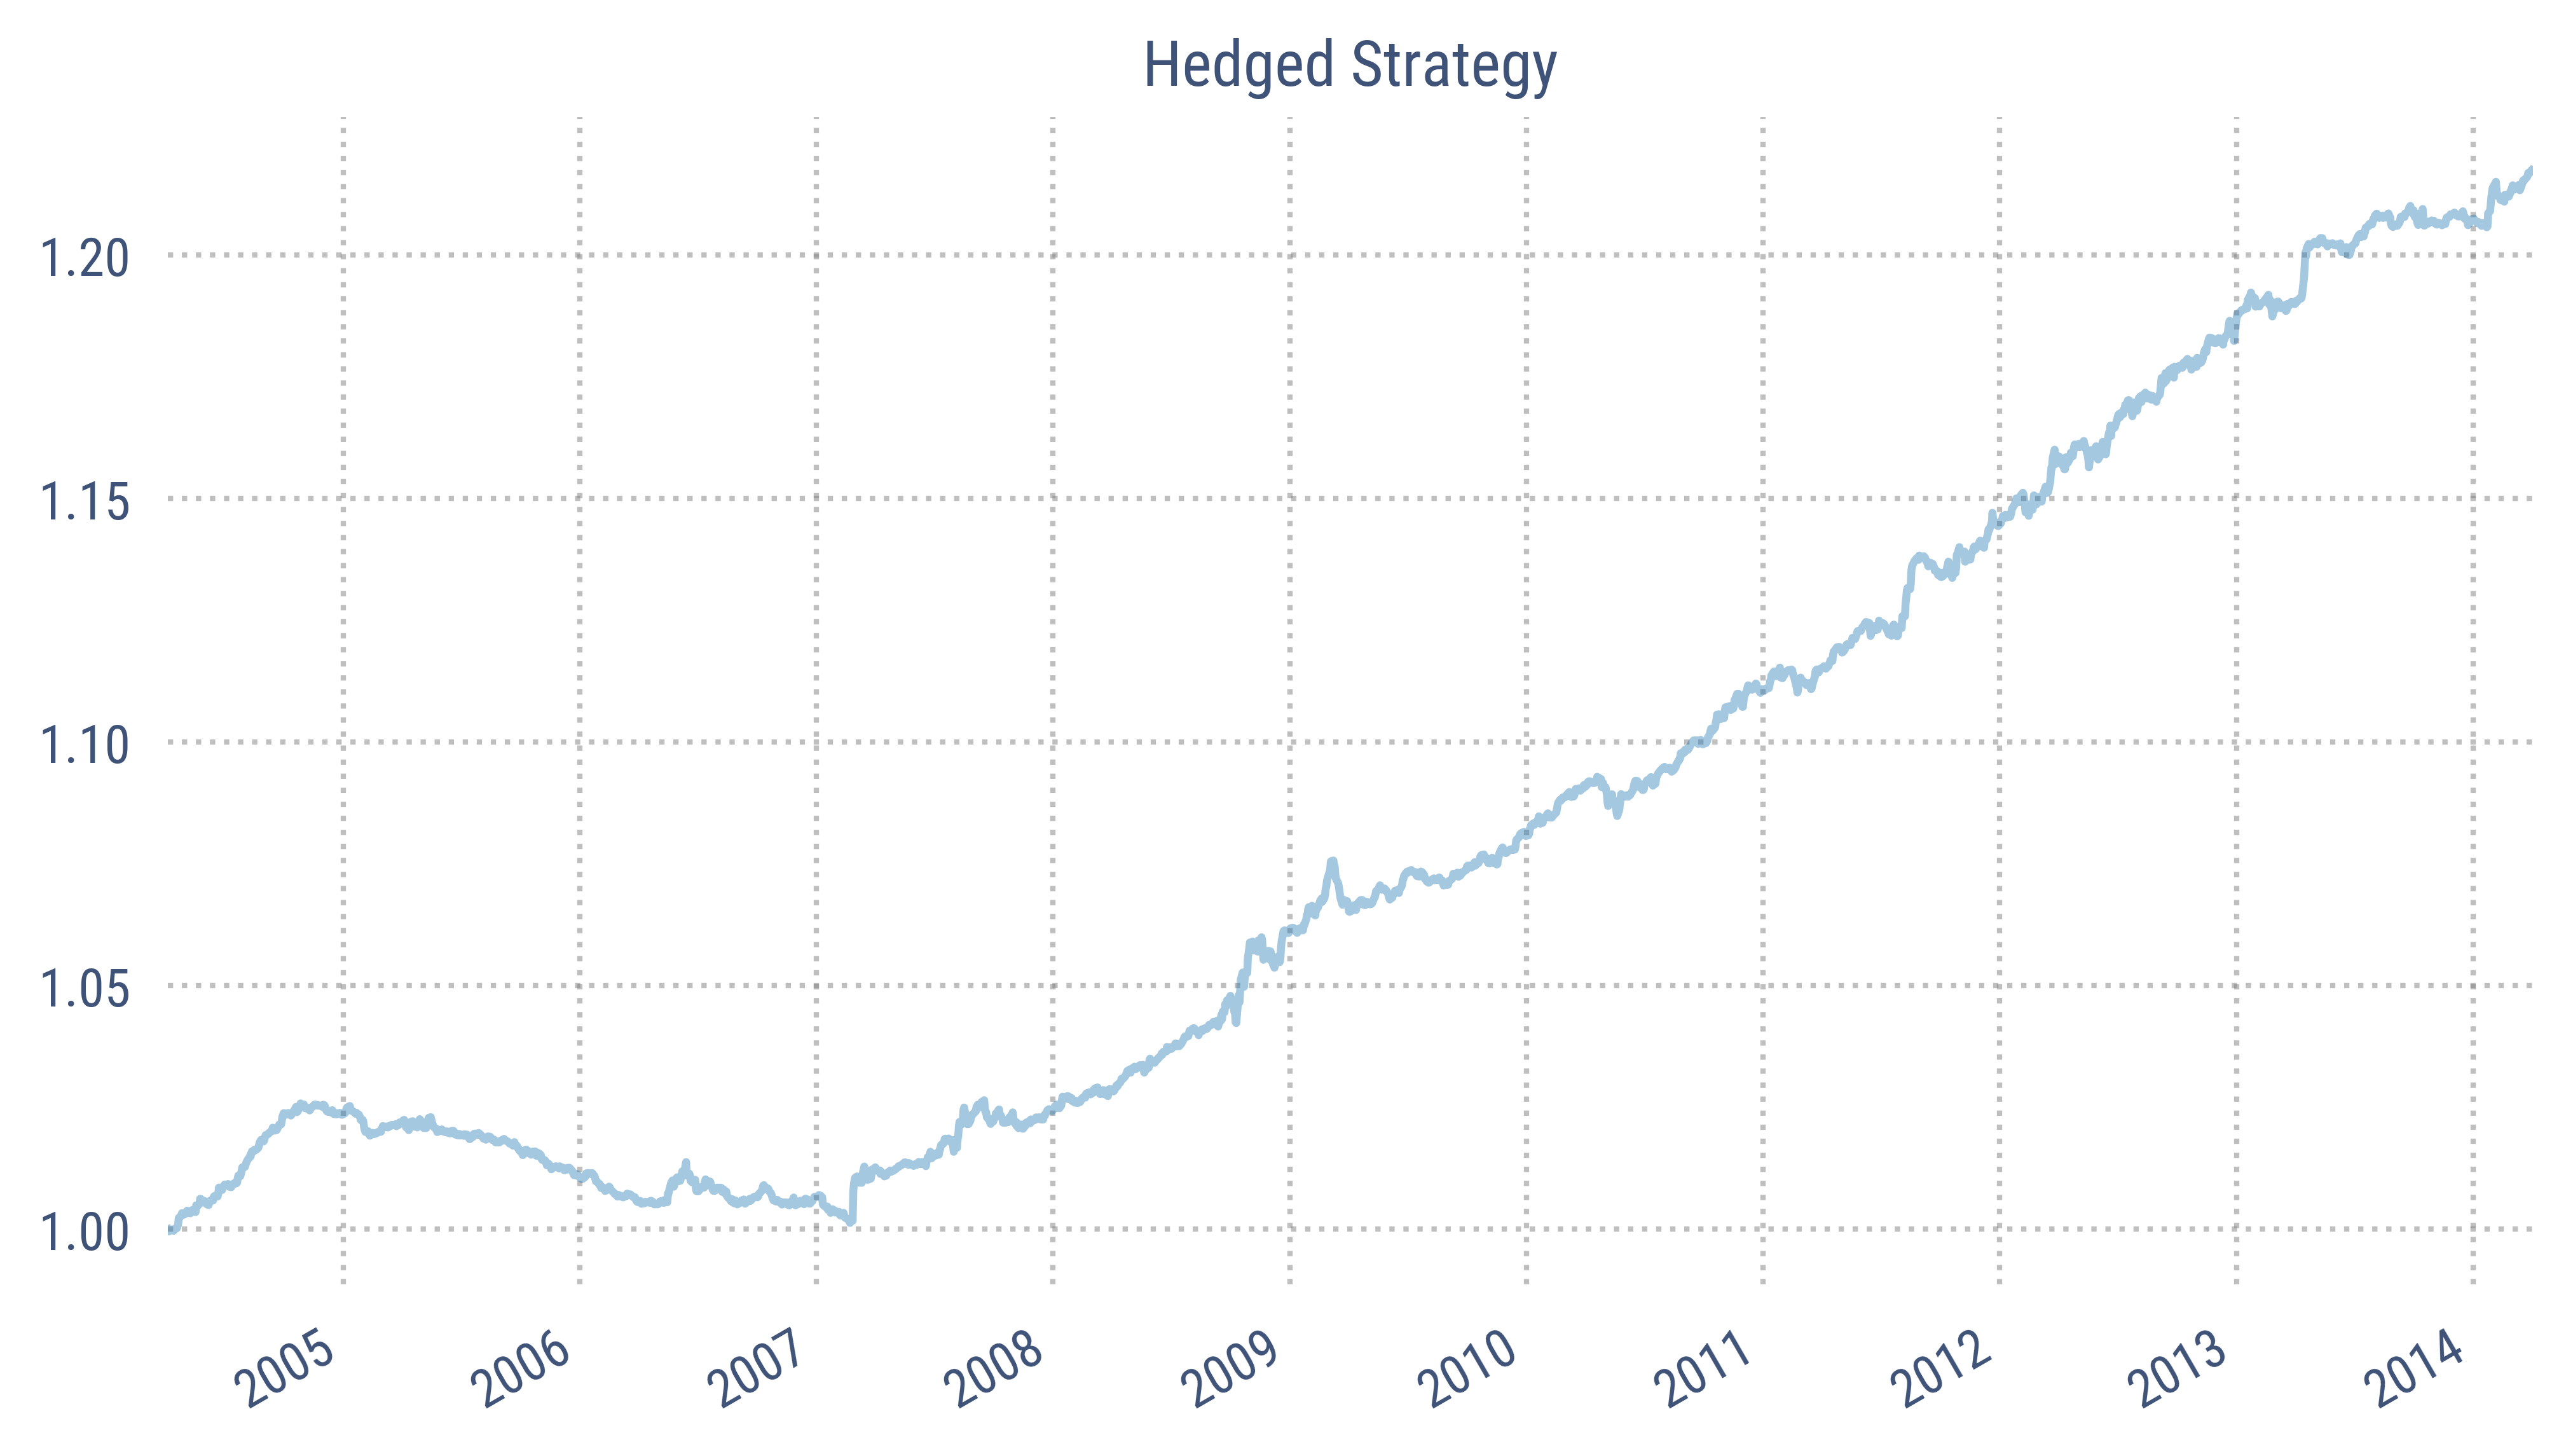

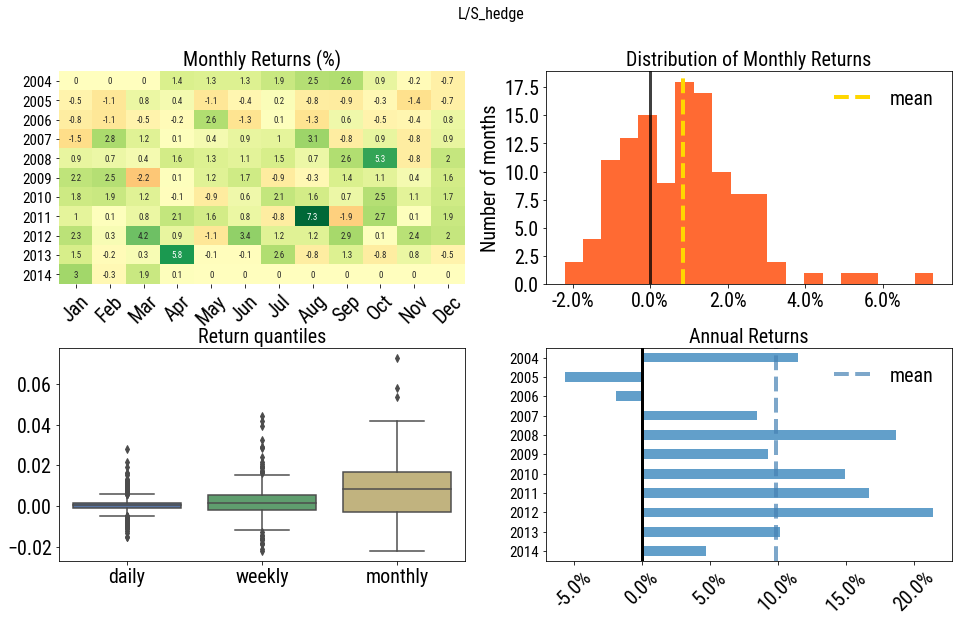

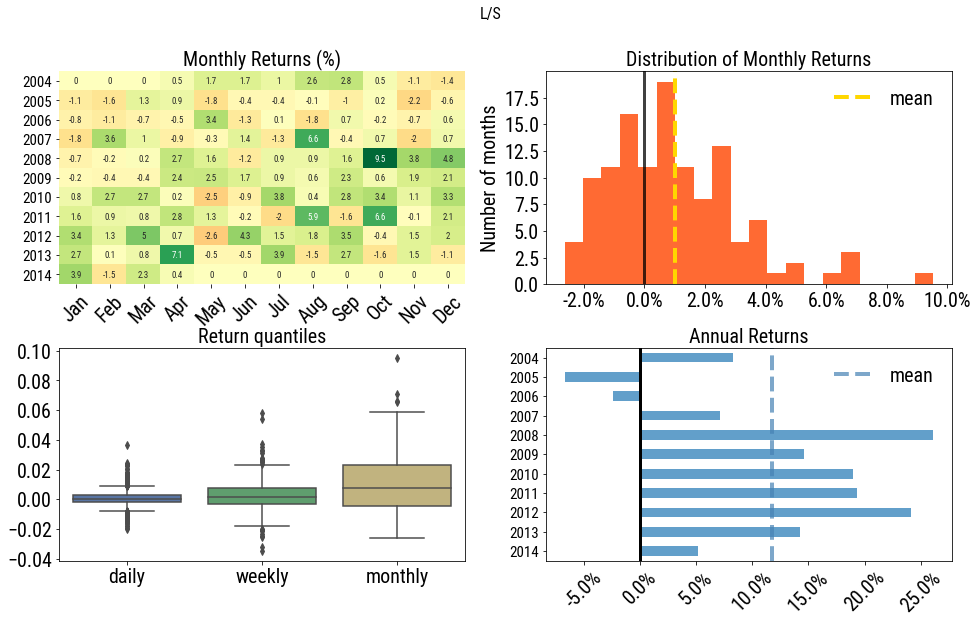

In [78]:
sp5_idx = sp5.excess_return_index[vixp_signal.index]
sp5_idx_short = 1 / sp5_idx
beta = 0.25
sp5_ret_long, sp5_ret_short = [item.pct_change() * beta for item in [sp5_idx, sp5_idx_short]]
hedge_ret = pd.concat([short_signal.astype(int) * sp5_ret_short, long_signal.astype(int) * sp5_ret_long], axis=1)
hedge_ret['Beta_hedge'] = hedge_ret.sum(axis=1)
hedged_strategy_ret = hedge_ret['Beta_hedge'] + signal_ret['L/S']
hedged_strategy_ret = hedged_strategy_ret.rename('L/S_hedge')
display(pd.concat([perf_stats(hedged_strategy_ret), 
           perf_stats(signal_ret['L/S']),
           perf_stats(hedge_ret['Beta_hedge'])], axis=1))
hedged_strategy_idx = pf.timeseries.cum_returns(hedged_strategy_ret, 100)
hedged_strategy_idx_log = np.log(hedged_strategy_idx)
hedged_strategy_idx_log = hedged_strategy_idx_log / hedged_strategy_idx_log[0]
fig = plt.figure(figsize=pc.fig_size,
                 dpi=600, 
                 facecolor='None', 
                 edgecolor='None')
gs = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.25)
ax_hed = plt.subplot(gs[:])
_ = hedged_strategy_idx_log.plot(lw=1.5,
                            ax=ax_hed, 
                            grid=True,
                            alpha=0.4,
                            title ='Hedged Strategy')

chart_format([ax_hed],pc.color_light)

plt.autoscale(enable=True,
              axis='x',
              tight=True)
_ = plot_performance_quad(hedged_strategy_ret)
_ = plot_performance_quad(signal_ret['L/S'])
drawdown_table_1 = pf.timeseries.gen_drawdown_table(hedged_strategy_ret, pc.font_size)
display(drawdown_table_1.style.set_caption(hedged_strategy_ret.name))


# Add Put Selling Program and Cash

Option files not updated
Running Simulation - trade_day_type:EOM | Z-score -1.5 | Duration 2 | Option Type:P
CPU times: user 34.8 s, sys: 2.37 s, total: 37.2 s
Wall time: 34.2 s


L/S_hedge  EOMP-1.5L1.0  S&P 500TR  VixP/Overlay/Cash
L/S_hedge           1.000000      0.211677   0.153628           0.747858
EOMP-1.5L1.0        0.211677      1.000000   0.747835           0.806858
S&P 500TR           0.153628      0.747835   1.000000           0.600429
VixP/Overlay/Cash   0.747858      0.806858   0.600429           1.000000

L/S_hedge  EOMP-1.5L1.0 VixP/Overlay/Cash
StartDate                Apr 06, 2004  Apr 06, 2004      Apr 06, 2004
EndDate                  Apr 03, 2014  Apr 03, 2014      Apr 03, 2014
annual_return                0.105558     0.0374867          0.164342
annual_volatility           0.0467215     0.0523901         0.0771826
sharpe_ratio                    2.172      0.728936           2.01091
calmar_ratio                 0.987849      0.305427           1.38906
stability_of_timeseries      0.950409      0.978435          0.981144
max_drawdown                -0.106856     -0.122736         -0.118311
omega_ratio                   1.50045       1.27789           1.58672
sortino_ratio                 3.59407      0.993305             3.072
skew                         0.730634      -1.73367          0.264715
kurtosis                      8.01331       89.3622           45.2248
tail_ratio                    1.30713       1.02688           1.25669

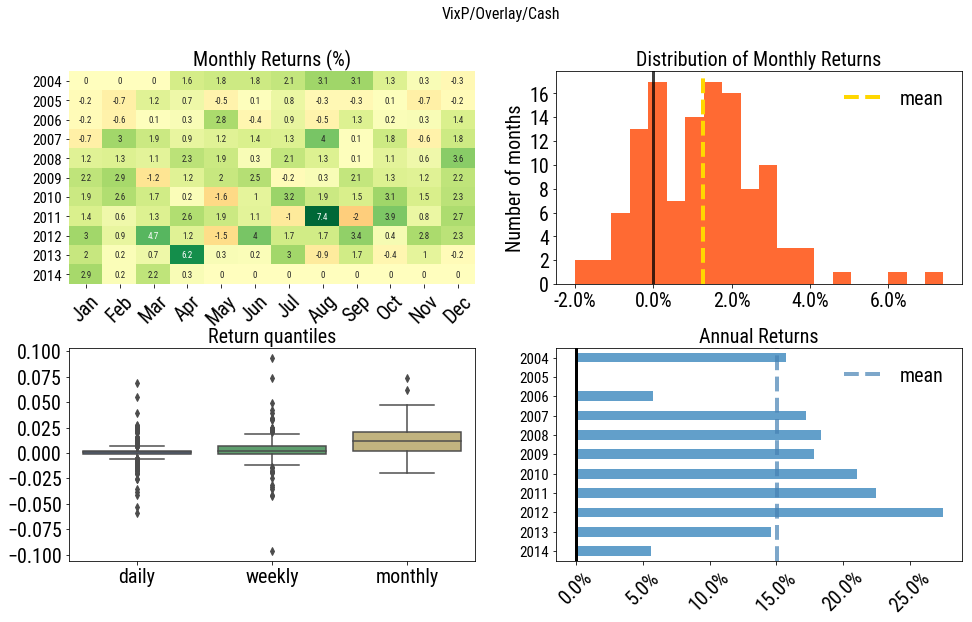

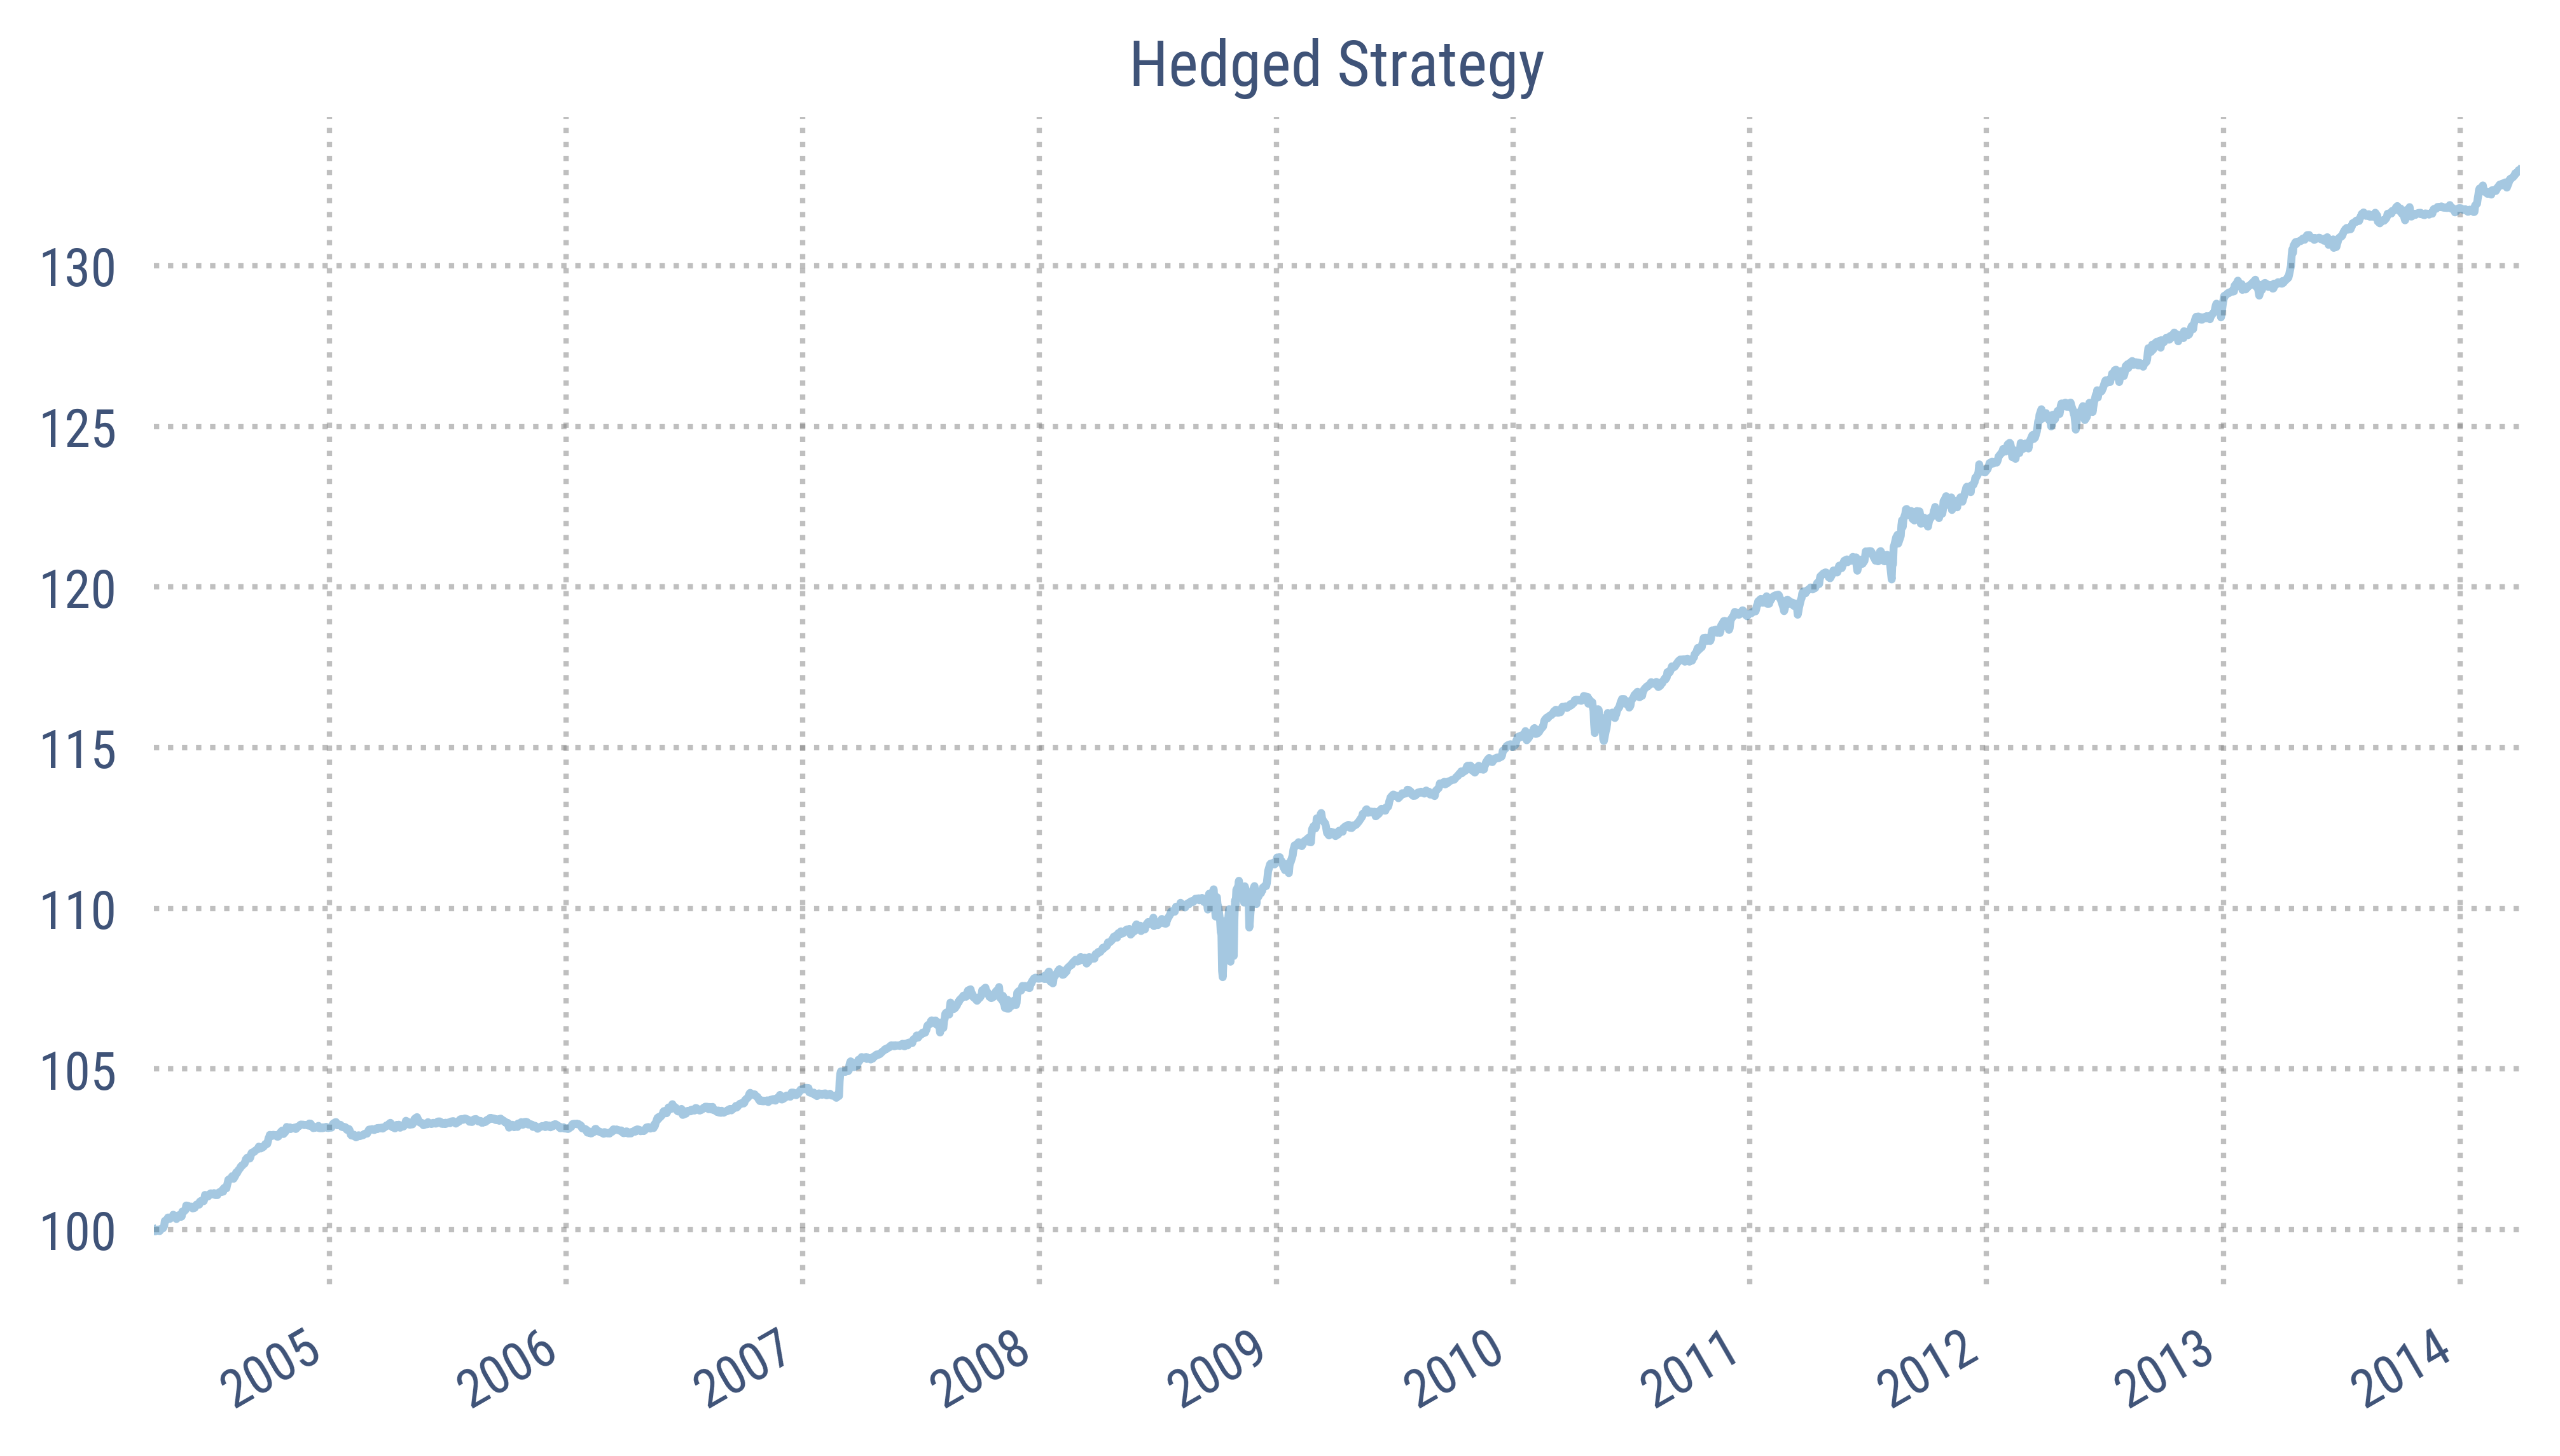

In [81]:
opt_sim = OptionSimulation(update_simulation_data=True)
z_score = -1.5
duration = 2
leverage = 1
sim_idx = 0
%time sim_output = [opt_sim.trade_sim(z_score, duration, trade_day_type=day_type) \
                    for day_type in ['EOM']]
opt_trade = [OptionTrades(sim, leverage=leverage) for sim in sim_output]

shared_dates = hedged_strategy_ret.index.intersection(opt_trade[0].returns.index)
total_port = hedged_strategy_ret[shared_dates] + opt_trade[0].returns[shared_dates]
total_port_idx = pf.timeseries.cum_returns(total_port, 100)


cash = opt_sim.usZeroYldCurve.cash_index[total_port_idx.index]
total_port_idx = total_port_idx * cash
total_port_idx = total_port_idx / total_port_idx[0] * 100
total_port_idx_log = np.log(total_port_idx)
total_port_idx_log = total_port_idx_log / total_port_idx_log[0] * 100

total_port = total_port_idx.pct_change().dropna(how='any')
total_port = total_port.rename('VixP/Overlay/Cash')
display(pd.concat([hedged_strategy_ret[shared_dates],
                   opt_trade[0].returns[shared_dates],
                  sp5.return_index.pct_change()[shared_dates],
                  total_port[shared_dates]], axis=1).corr())
plot_performance_quad(total_port)
display(pd.concat([perf_stats(hedged_strategy_ret[total_port.index]),
                   perf_stats(opt_trade[0].returns[total_port.index]),
                   perf_stats(total_port)], axis=1))

fig = plt.figure(figsize=pc.fig_size,
                 dpi=600, 
                 facecolor='None', 
                 edgecolor='None')
gs = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.25)
ax_total = plt.subplot(gs[:])
ax_total = total_port_idx_log.plot(lw=1.5,
                            ax=ax_total, 
                            grid=True,
                            alpha=0.4,
                            title ='Hedged Strategy')

chart_format([ax_total], pc.color_light)
plt.autoscale(enable=True,
              axis='x',
              tight=True)
drawdown_table_2 = pf.timeseries.gen_drawdown_table(total_port)

display(drawdown_table_2.style.set_caption(total_port.name))


In [83]:
foo = pd.concat([short_signal.astype(int).rename('short'), 
                 long_signal.astype(int).rename('long'),
                 vixp_signal*10000,
                vix], axis=1)
foo.dropna(how='any').style


In [5]:
vx.raw_tsm_df

open1  high1   low1  close1        v1       oi1        exp1  \
2004-04-05  18.73  18.80  18.55   18.53      84.0     804.0  20040518.0   
2004-04-06  18.57  18.89  18.57   18.79     304.0    1126.0  20040518.0   
2004-04-07  18.97  19.25  18.89   19.09      52.0    1325.0  20040518.0   
2004-04-08  18.95  19.15  18.95   19.05      98.0    1485.0  20040518.0   
2004-04-12  18.78  18.78  18.70   18.67      52.0    1486.0  20040518.0   
2004-04-13  19.00  19.31  18.89   19.30      25.0    1464.0  20040518.0   
2004-04-14  19.38  19.50  19.38   19.46     308.0    1589.0  20040518.0   
2004-04-15  19.33  19.44  19.26   19.26     142.0    1667.0  20040518.0   
2004-04-16  19.18  19.19  19.00   19.00      61.0    1718.0  20040518.0   
2004-04-19  19.10  19.14  18.85   18.85      11.0    1723.0  20040518.0   
2004-04-20  18.87  19.11  18.65   19.15     125.0    1836.0  20040518.0   
2004-04-21  19.09  19.10  18.64   18.68      11.0    1817.0  20040518.0   
2004-04-22  18.55  18.55  17.14   17.35      95.0    1884.0  20040518.0   
2004-04-23  17.23  17.50  17.23   17.34     601.0    1461.0  20040518.0   
2004-04-26  17.30  17.39  17.23   17.13     246.0    1282.0  20040518.0   
2004-04-27  17.12  17.12  16.50   16.80      52.0    1290.0  20040518.0   
2004-04-28  17.05  17.51  17.00   17.37     440.0    1108.0  20040518.0   
2004-04-29  17.23  17.91  17.23   17.77     274.0    1115.0  20040518.0   
2004-04-30  17.54  18.28  17.54   18.22     131.0    1018.0  20040518.0   
2004-05-03  18.00  18.00  17.80   17.69      42.0     934.0  20040518.0   
2004-05-04  17.60  17.68  16.85   17.31     440.0     930.0  20040518.0   
2004-05-05  17.04  17.05  16.60   16.62     237.0     996.0  20040518.0   
2004-05-06  16.85  17.65  16.85   17.48      41.0    1034.0  20040518.0   
2004-05-07  17.54  18.14  17.12   18.31     136.0    1083.0  20040518.0   
2004-05-10  18.79  19.58  18.60   19.35     219.0    1198.0  20040518.0   
2004-05-11  18.90  18.90  18.33   18.38      85.0    1109.0  20040518.0   
2004-05-12  18.31  19.40  18.31   18.20     162.0    1166.0  20040518.0   
2004-05-13  18.38  18.38  18.00   18.38      99.0    1222.0  20040518.0   
2004-05-14  18.45  18.73  18.17   18.55      38.0    1228.0  20040518.0   
2004-05-17  19.17  19.50  18.90   19.37     207.0    1195.0  20040518.0   
...           ...    ...    ...     ...       ...       ...         ...   
2014-02-21  14.95  15.20  14.65   15.15   73667.0  169477.0  20140318.0   
2014-02-24  15.05  15.15  14.74   15.00   57210.0  168480.0  20140318.0   
2014-02-25  14.97  15.30  14.80   14.90   58450.0  165801.0  20140318.0   
2014-02-26  14.90  15.42  14.70   15.30   77641.0  163827.0  20140318.0   
2014-02-27  15.25  15.56  15.05   15.10   67448.0  155954.0  20140318.0   
2014-02-28  15.05  15.70  14.80   15.25   88720.0  152185.0  20140318.0   
2014-03-03  15.90  17.03  15.90   16.60  116958.0  140956.0  20140318.0   
2014-03-04  16.55  16.55  15.00   15.10   81113.0  139349.0  20140318.0   
2014-03-05  15.10  15.40  14.95   15.15   61080.0  129192.0  20140318.0   
2014-03-06  15.13  15.25  14.90   15.05   45965.0  125995.0  20140318.0   
2014-03-07  15.05  15.65  14.70   15.50   78297.0  118941.0  20140318.0   
2014-03-10  15.60  15.95  15.15   15.30   60520.0  107583.0  20140318.0   
2014-03-11  15.30  15.55  14.84   15.55   68149.0   98243.0  20140318.0   
2014-03-12  15.45  16.00  15.24   15.30   57063.0   86879.0  20140318.0   
2014-03-13  15.25  16.80  15.00   16.60  103026.0   68015.0  20140318.0   
2014-03-14  16.60  18.00  16.45   17.70  115949.0   45590.0  20140318.0   
2014-03-17  16.15  16.15  16.15   16.15   65211.0   30198.0  20140318.0   
2014-03-18  15.46  15.46  15.46   15.46       0.0   22375.0  20140318.0   
2014-03-19  15.60  16.45  15.40   16.00  109085.0  145948.0  20140415.0   
2014-03-20  15.95  16.15  15.65   15.75   62272.0  144638.0  20140415.0   
2014-03-21  15.75  16.00  15.50   16.00   84344.0  145565.0  20140415.0   
2014-03-24  15.90  16.40  15.64   15.